# Quantization in TFLite

In this post, you will get to explore quantizing a model in TFLite again. This time some of the code will be missing and you'll need to fill it in. The model we are exploring today is a computer vision model that recognizes hand gestures for the rock, paper, scissors game! This is the summary of lecture "Applications of TinyML" from edX.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, edX, Deep_Learning, Tensorflow, tinyML]
- image: 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tqdm import tqdm
import pathlib

## Download the dataset

In [2]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label


(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'rock_paper_scissors', split=['train[:80%]', 'train[80%:]', 'test'], 
    with_info=True, as_supervised=True)
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

Shuffling and writing examples to C:\/Users/kcsgo/tensorflow_datasets/rock_paper_scissors/3.0.0.incompletePG0RGX/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to C:\/Users/kcsgo/tensorflow_datasets/rock_paper_scissors/3.0.0.incompletePG0RGX/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to C:\Users\kcsgo\tensorflow_datasets\rock_paper_scissors\3.0.0. Subsequent calls will reuse this data.


## Build and train a baseline model

In [3]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/5
63/63 [==============================] - 21s 332ms/step - loss: 0.4361 - accuracy: 0.8681 - val_loss: 0.1206 - val_accuracy: 0.9841
Epoch 2/5
63/63 [==============================] - 2s 25ms/step - loss: 0.0840 - accuracy: 0.9931 - val_loss: 0.0580 - val_accuracy: 0.9960
Epoch 3/5

## Save the baseline model

In [4]:
ROCK_PAPER_SCISSORS_SAVED_MODEL = "exp_saved_model"
tf.saved_model.save(model, ROCK_PAPER_SCISSORS_SAVED_MODEL)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: exp_saved_model\assets


INFO:tensorflow:Assets written to: exp_saved_model\assets


## Convert the model to TFLite

In [6]:
converter = tf.lite.TFLiteConverter.from_saved_model(ROCK_PAPER_SCISSORS_SAVED_MODEL)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path('./')
tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)

8950040

## Test the model

In [8]:
# Load TFLite model and allocate tensors
TFLITE_MODEL_FILE = './model1.tflite'
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_FILE)
interpreter.allocate_tensors()

In [9]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

# This will tell you how many of the predictions were correct
score = 0
for item in range(0,99):
    prediction=np.argmax(predictions[item])
    label = test_labels[item]
    if prediction==label:
        score=score+1

print("\nOut of 100 predictions I got " + str(score) + " correct")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.76it/s]


Out of 100 predictions I got 81 correct


## Plot the results

In [10]:
class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

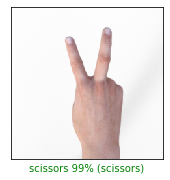

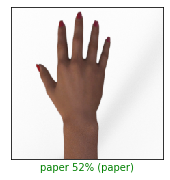

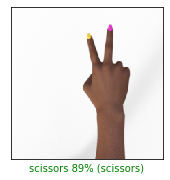

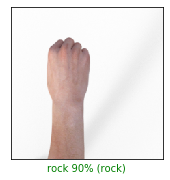

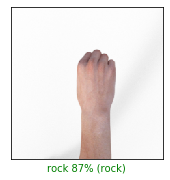

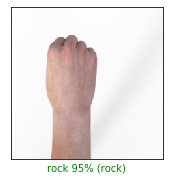

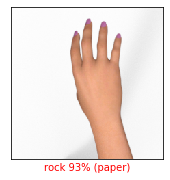

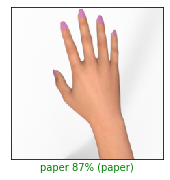

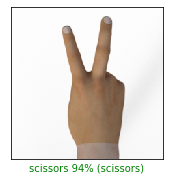

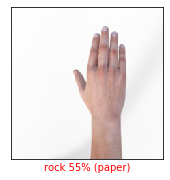

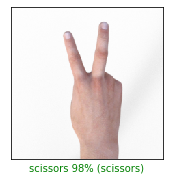

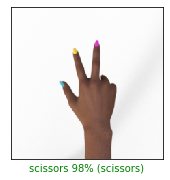

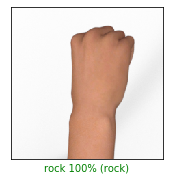

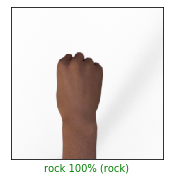

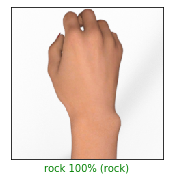

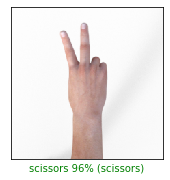

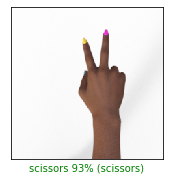

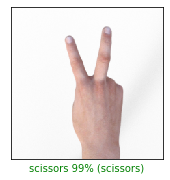

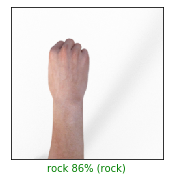

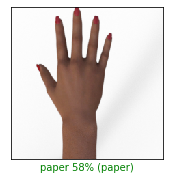

In [11]:
max_index = 20
for index in range(0, max_index):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(index, predictions, test_labels, test_imgs)
    plt.show()

## Further Study

We are going to dive a little deeper into the ideas behind post-training quantization and optimization in the next section. That said, if you'd like to check out how these steps are implemetned in Tensorflow Lite, please check out the user guides at https://www.tensorflow.org/lite/performance/post_training_quantization.